In [1]:
import random
import numpy as np
import tensorflow as tf
import os

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam

In [3]:
train_dir = '/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train'
val_dir = '/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val'

In [4]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


In [5]:
image_size = (176, 208)  # as per the GAN experiments
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode='grayscale',
    class_mode="sparse",
    shuffle=True,
    seed=SEED,
    batch_size=batch_size
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    color_mode='grayscale',
    class_mode="sparse",
    batch_size=batch_size,
    seed=SEED,
    shuffle=False
)

Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(176, 208, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 174, 206, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 174, 206, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 87, 103, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 85, 101, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 85, 101, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 40, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61440)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,864,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,958,532 (30.36 MB)

 Trainable params: 7,958,084 (30.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_gen,
    epochs=40,
    validation_data=val_gen,
    callbacks=[early_stop]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 63s 51ms/step - accuracy: 0.3437 - loss: 1.4686 - val_accuracy: 0.5669 - val_loss: 0.9766
Epoch 2/40
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 52s 49ms/step - accuracy: 0.4258 - loss: 1.0861 - val_accuracy: 0.7186 - val_loss: 0.7206
Epoch 3/40
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 54s 50ms/step - accuracy: 0.5305 - loss: 0.9126 - val_accuracy: 0.7200 - val_loss: 0.6609
Epoch 4/40
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 57s 53ms/step - accuracy: 0.5867 - loss: 0.8245 - val_accuracy: 0.7827 - val_loss: 0.5605
Epoch 5/40
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 53s 50ms/step - accuracy: 0.6238 - loss: 0.7755 - val_accuracy: 0.7327 - val_loss: 0.5371
Epoch 6/40
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 53s 49ms/step - accuracy: 0.6799 - loss: 0.6964 - val_accuracy: 0.8616 - val_loss: 0.3695
Epoch 7/40
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 54s 50ms/step - accuracy: 0.7023 - loss: 0.6458 - val_accuracy: 0.9078 - val_loss: 0.2858
Epoch 8/40
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - accuracy: 0.7192 - loss: 0.61

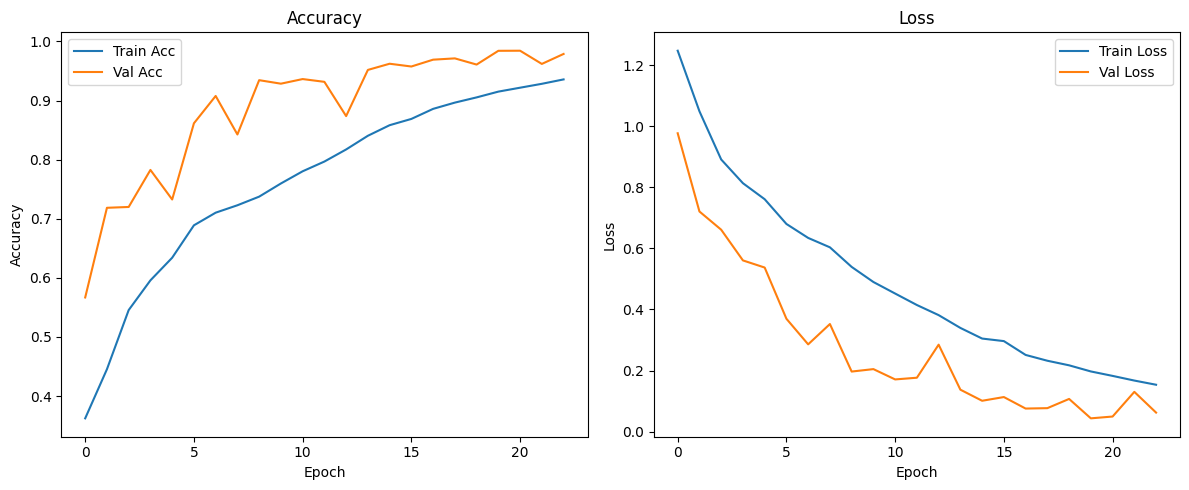

In [8]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      1.00       896
ModerateDemented       1.00      1.00      1.00        64
     NonDemented       0.99      0.98      0.98      3200
VeryMildDemented       0.97      0.98      0.98      2240

        accuracy                           0.98      6400
       macro avg       0.99      0.99      0.99      6400
    weighted avg       0.98      0.98      0.98      6400



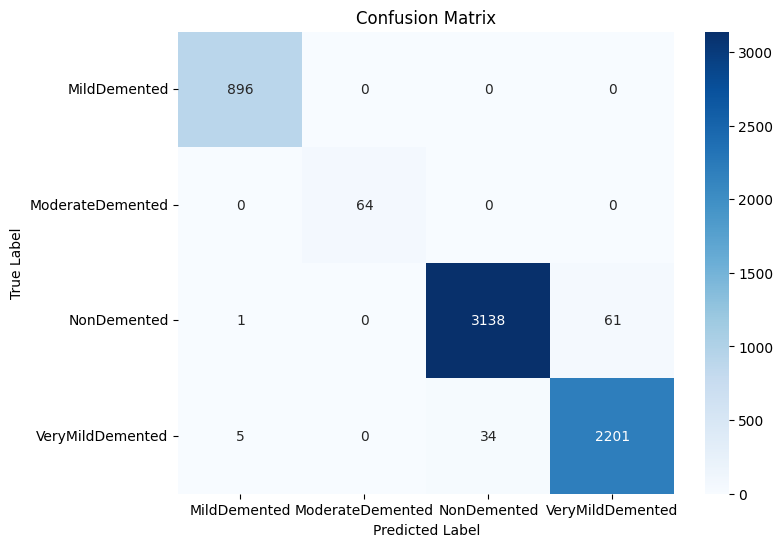

In [9]:
import numpy as np

val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

# Labels
labels = list(val_gen.class_indices.keys())

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Found 33984 images belonging to 4 classes.
   3/1062 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step

✅ Training Accuracy: 0.9773

📊 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.96      1.00      0.98      8960
ModerateDemented       1.00      1.00      1.00      6464
     NonDemented       0.99      0.96      0.98      9600
VeryMildDemented       0.96      0.96      0.96      8960

        accuracy                           0.98     33984
       macro avg       0.98      0.98      0.98     33984
    weighted avg       0.98      0.98      0.98     33984



<ipython-input-10-b6f4068b5f81>:46: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


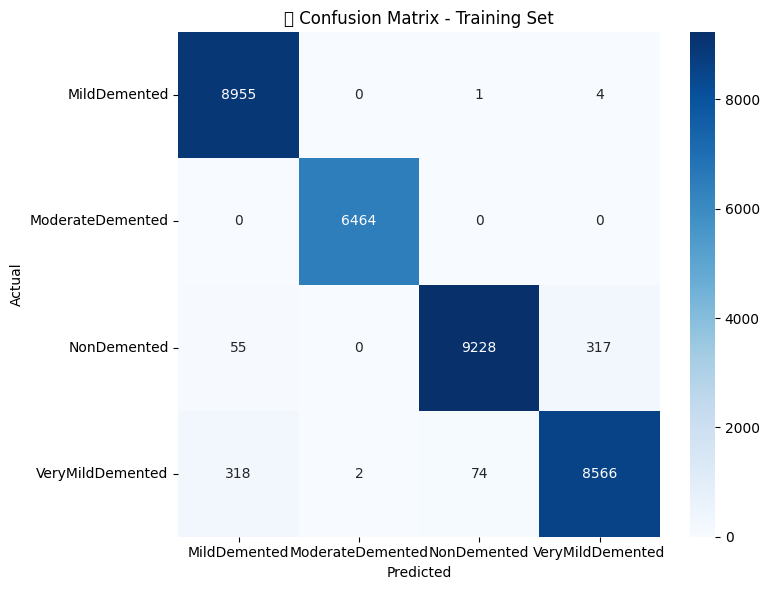

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

IMG_SIZE = (176, 208)
BATCH_SIZE = 32

# Path to training data
train_dir = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train"

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode="sparse",
    shuffle=False,
    batch_size=BATCH_SIZE
)

# Predict
y_true = train_generator.classes
y_pred_probs = model.predict(train_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(train_generator.class_indices.keys())

# Accuracy
accuracy = np.mean(y_pred == y_true)
print(f"\nTraining Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
import os
import zipfile

# 1. Save the model in HDF5 format (.h5)
model_save_path = "alzheimers_augmented_model_latest.h5"
model.save(model_save_path)
print(f"Model saved as: {model_save_path}")

# 2. Zip the saved model
zip_filename = "alzheimers_augmented_model.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(model_save_path)

print(f"Model zipped as: {zip_filename}")

# 3. Make it downloadable in Kaggle
from IPython.display import FileLink
FileLink(zip_filename)


✅ Model saved as: alzheimers_augmented_model_latest.h5
📦 Model zipped as: alzheimers_augmented_model.zip


/kaggle/working/alzheimers_augmented_model.zip